In [0]:
import time
import os
import os.path
from osgeo import gdal, ogr, osr
from scipy import ndimage
from scipy import misc
from io import StringIO
gdal.UseExceptions()
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import urllib
import pandas as pd
import numpy as np 


In [0]:

def read_raster(raster_file):
    """
    Function
    --------
    read_raster

    Given a raster file, get the pixel size, pixel location, and pixel value

    Parameters
    ----------
    raster_file : string
        Path to the raster file

    Returns
    -------
    x_size : float
        Pixel size
    top_left_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the top-left point in each pixel
    top_left_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the top-left point in each pixel
    centroid_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the centroid in each pixel
    centroid_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the centroid in each pixel
    bands_data : numpy.ndarray  shape: (number of rows, number of columns, 1)
        Pixel value
    """
    raster_dataset = gdal.Open(raster_file, gdal.GA_ReadOnly)
    # get project coordination
    proj = raster_dataset.GetProjectionRef()
    bands_data = []
    # Loop through all raster bands
    for b in range(1, raster_dataset.RasterCount + 1):
        band = raster_dataset.GetRasterBand(b)
        bands_data.append(band.ReadAsArray())
        no_data_value = band.GetNoDataValue()
    bands_data = np.dstack(bands_data)
    rows, cols, n_bands = bands_data.shape

    # Get the metadata of the raster
    geo_transform = raster_dataset.GetGeoTransform()
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = geo_transform
    
    # Get location of each pixel
    x_size = 1.0 / int(round(1 / float(x_size)))
    y_size = - x_size
    y_index = np.arange(bands_data.shape[0])
    x_index = np.arange(bands_data.shape[1])
    top_left_x_coords = upper_left_x + x_index * x_size
    top_left_y_coords = upper_left_y + y_index * y_size
    # Add half of the cell size to get the centroid of the cell
    centroid_x_coords = top_left_x_coords + (x_size / 2)
    centroid_y_coords = top_left_y_coords + (y_size / 2)

    return (x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data)

In [0]:


# Helper function to get the pixel index of the point
def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    """
    Function
    --------
    get_cell_idx

    Given a point location and all the pixel locations of the raster file,
    get the column and row index of the point in the raster

    Parameters
    ----------
    lon : float
        Longitude of the point
    lat : float
        Latitude of the point
    top_left_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the top-left point in each pixel
    top_left_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the top-left point in each pixel
    
    Returns
    -------
    lon_idx : int
        Column index
    lat_idx : int
        Row index
    """
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx


In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls

drive  sample_data


In [0]:
os.chdir('/content/drive/My Drive/Thesis')
raster_file = '/content/drive/My Drive/Thesis/F182013.v4c_web.stable_lights.avg_vis.tif'
x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data = read_raster(raster_file)

# save the result in compressed format - see https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html
np.savez('nightlight.npz', top_left_x_coords=top_left_x_coords, top_left_y_coords=top_left_y_coords, bands_data=bands_data)


In [0]:
# get nightlight features for each cluster
def get_nightlight_feature(sample):
    idx, wealth, x, y = sample
    lon_idx, lat_idx = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    # Select the 10 * 10 pixels
    left_idx = lon_idx - 5
    right_idx = lon_idx + 4
    up_idx = lat_idx - 5
    low_idx = lat_idx + 4
    luminosity_100 = []
    for i in range(left_idx, right_idx + 1):
        for j in range(up_idx, low_idx + 1):
            # Get the luminosity of this pixel
            luminosity = bands_data[j, i, 0]
            luminosity_100.append(luminosity)
    luminosity_100 = np.asarray(luminosity_100)
    max_ = np.max(luminosity_100)
    min_ = np.min(luminosity_100)
    mean_ = np.mean(luminosity_100)
    median_ = np.median(luminosity_100)
    std_ = np.std(luminosity_100)
    return pd.Series({'id': idx, 'max_': max_, 'min_': min_, 'mean_': mean_, 
                      'median_': median_, 'std_': std_, 'wealth': wealth})

dhs_path = '/content/drive/My Drive/Thesis/DHS_Data/bangladesh_cluster_avg_asset_2013_updated_new.csv'
clusters = pd.read_csv(dhs_path)
data_all = clusters.apply(lambda x: get_nightlight_feature([x['cluster'], x['wlthindf'], x['longitude'], x['latitude']]), axis=1)
data_all.to_csv('DHS_nightlights.csv', index=None)

(0.0, 50.0)

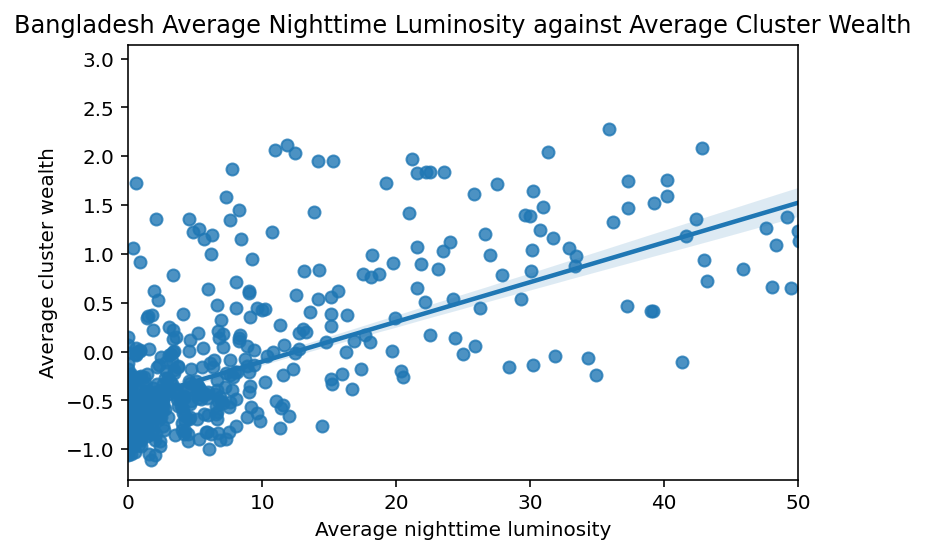

In [0]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

ax = sns.regplot(x="mean_", y="wealth", data=data_all)
plt.xlabel('Average nighttime luminosity')
plt.ylabel('Average cluster wealth')
plt.title("Bangladesh Average Nighttime Luminosity against Average Cluster Wealth")
plt.xlim([0, 50])


In [0]:
#fit a model of wealth as a function of nightlights 

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

data_all = pd.read_csv('DHS_nightlights.csv')
data_all = data_all[['max_', 'min_', 'mean_', 'median_', 'std_', 'wealth']].as_matrix()
np.random.seed(123)

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Ridge(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the best model: {np.max(final)}')

R^2 of the best model: 0.6001952206605662


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [0]:
from sklearn.linear_model import Lasso

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Lasso(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the best model: {np.max(final)}')

R^2 of the best model: 0.5969722054084954


In [0]:
from sklearn.linear_model import ElasticNet

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = ElasticNet(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the best model: {np.max(final)}')


R^2 of the best model: 0.586808396578341


In [0]:
from sklearn.ensemble import RandomForestRegressor

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = RandomForestRegressor()
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the best model: {np.max(final)}')


R^2 of the best model: 0.5772423358879502


In [0]:
def get_shp_extent(shp_file):
    """
    Function
    --------
    get_shp_extent
    Given a shapefile, get the extent (boundaries)
    Parameters
    ----------
    shp_file : string
        Path to the shapefile
    Returns
    -------
    extent : tuple
        Boundary location of the shapefile (x_min, x_max, y_min, y_max)
    """
    inDriver = ogr.GetDriverByName("ESRI Shapefile")
    inDataSource = inDriver.Open(shp_file, 0)
    if inDataSource is None:
        print(f'Could not open {shp_file}')
    else:
      print('Opened %s' % (shp_file))
      inLayer = inDataSource.GetLayer()
      extent = inLayer.GetExtent()
      # x_min_shp, x_max_shp, y_min_shp, y_max_shp = extent
      return extent


In [0]:
# Helper functions to download images from Google Maps API

from retrying import retry
import urllib.request
from io import BytesIO
from PIL import Image

@retry(wait_exponential_multiplier=1000, wait_exponential_max=3600000)
def save_img(url, file_path, file_name):
    """
    Function
    --------
    save_img
    Given a url of the map, save the image
    Parameters
    ----------
    url : string
        URL of the map from Google Map Static API
    file_path : string
        Folder name of the map
    file_name : string
        File name
    Returns
    -------
    None
    """
    a = urllib.request.urlopen(url).read()
    b = BytesIO(a)
    #image = ndimage.imageio.imread(b, mode='RGB')
    image = np.asarray(Image.open(b).convert("RGB"))
    # when no image exists, api will return an image with the same color.
    # and in the center of the image, it said'Sorry. We have no imagery here'.
    # we should drop these images if large area of the image has the same color.
    if np.array_equal(image[:,:10,:],image[:,10:20,:]):
        pass
    else:
        plt.imsave(file_path + file_name, image[50:450, :, :])
        
# print-out help / instructions
def help():
    print('\nusage:')
    print('use --keyid= for setting the Google Maps Static API key number.')
    print('use --topidx= for setting the top row to start looping over the country.')
    print('(note: the top-left index should not be altered.)\n')


In [0]:
# Now read in the shapefile for Bangladesh and extract the edges of the country
inShapefile = '/content/drive/My Drive/Thesis/Bangladesh Shapefile Ver 2/polbndl_bgd.shp'
x_min_shp, x_max_shp, y_min_shp, y_max_shp = get_shp_extent(inShapefile)



Opened /content/drive/My Drive/Thesis/Bangladesh Shapefile Ver 2/polbndl_bgd.shp


In [0]:
x_min_shp, x_max_shp, y_min_shp, y_max_shp

(88.01142055700018, 92.6846781800001, 20.488732547000154, 26.632813377000048)

In [0]:
left_idx, top_idx = get_cell_idx(x_min_shp, y_max_shp, top_left_x_coords, top_left_y_coords)
right_idx, bottom_idx = get_cell_idx(x_max_shp, y_min_shp, top_left_x_coords, top_left_y_coords)


In [0]:
left_idx, top_idx, right_idx, bottom_idx

(32161, 5804, 32722, 6541)

In [0]:
os.chdir('/content/drive/My Drive/Thesis/google_images')

In [0]:
#key = 'apikey'
m = 1
for i in range(left_idx, right_idx + 1):
    for j in range(top_idx, bottom_idx + 1):
        lon = centroid_x_coords[i]
        lat = centroid_y_coords[j]
        url = 'https://maps.googleapis.com/maps/api/staticmap?center="' + str(lat) + ',' + \
                str(lon) + '"&zoom=16&size=400x500&maptype=satellite&key=' + key
        lightness = bands_data[j, i, 0]
        file_path = '/content/drive/My Drive/Thesis/google_images/' + str(lightness) + '/'
        if not os.path.isdir(file_path):
            os.makedirs(file_path)
        file_name = str(i) + '_' + str(j) +'.jpg'
        save_img(url, file_path, file_name)
        if m % 100 == 0:
            print(m)
        m += 1
        if m == 24900:
            print('\ntop-left corner i:%s, j:%s\nfinal cell i: %s, j:%s\n(N=%s iterations)\n' % (left_idx, top_idx, i, j, m))
            break 
            exit()

  # print final indices
print('\ntop-left corner i:%s, j:%s\nfinal cell i: %s, j:%s\n(N=%s iterations)\n' % (left_idx, top_idx, i, j, m))

100


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



top-left corner i:32418, j:6349
final cell i: 32418, j:6541
(N=194 iterations)



### Extract Daytime Image Features

In [0]:
#Change to Daytime Analysis folder
os.chdir('/content/drive/My Drive/Thesis/daytime_analysis')


In [0]:
import pickle
with open('images_name', 'rb') as fp:
  images_name = pickle.load(fp)


In [0]:
#Use regular expression to 

import re

#pattern = '[0-9][0-9][0-9][0-9][0-9]\_[0-9][0-9][0-9][0-9]\([0-9]\)\.jpeg'
pattern = '[0-9]{5}_[0-9]{4}\([0-9]\)\.jpg'
string = '32161_5809(1).jpg'

result = re.match(pattern, string)
if result:
  print("Search successful")
else:
  print("Search unsuccesful")


Search successful


In [0]:
pattern = '[0-9]{5}_[0-9]{4}\([0-9]\)\.jpg'
replace = None


for i in range(0, len(images_name)): 
  list_within = images_name[i]
  for item in list_within: 
    match = re.search(pattern, string)

In [0]:
#Use regular expression to filter and delete duplicate files with pattern of (1) at the end of the file

new_images_name = []

regex = re.compile(r'[0-9]{5}_[0-9]{4}\([0-9]\)\.jpg')

for i in range(0, len(images_name)): 
  list_within = images_name[i]
  filtered = [image for image in list_within if not regex.search(image)]
  new_images_name.append(filtered)

# use only one of the following lines, whichever you prefer
#filtered = filter(lambda i: not regex.search(i), full)
#filtered = [i for i in full if not regex.search(i)]


In [0]:
#search and see if there's still duplicate in new images_name
pattern = '[0-9]{5}_[0-9]{4}\([0-9]\)\.jpg'

for i in range(0, len(new_images_name)): 
  list_within = new_images_name[i]
  for item in list_within: 
    match = re.search(pattern, string)
    print(match)


Streaming output truncated to the last 5000 lines.
<_sre.SRE_Match object; span=(0, 17), match='32161_5809(1).jpg'>
<_sre.SRE_Match object; span=(0, 17), match='32161_5809(1).jpg'>
<_sre.SRE_Match object; span=(0, 17), match='32161_5809(1).jpg'>
<_sre.SRE_Match object; span=(0, 17), match='32161_5809(1).jpg'>
<_sre.SRE_Match object; span=(0, 17), match='32161_5809(1).jpg'>
<_sre.SRE_Match object; span=(0, 17), match='32161_5809(1).jpg'>
<_sre.SRE_Match object; span=(0, 17), match='32161_5809(1).jpg'>
<_sre.SRE_Match object; span=(0, 17), match='32161_5809(1).jpg'>
<_sre.SRE_Match object; span=(0, 17), match='32161_5809(1).jpg'>
<_sre.SRE_Match object; span=(0, 17), match='32161_5809(1).jpg'>
<_sre.SRE_Match object; span=(0, 17), match='32161_5809(1).jpg'>
<_sre.SRE_Match object; span=(0, 17), match='32161_5809(1).jpg'>
<_sre.SRE_Match object; span=(0, 17), match='32161_5809(1).jpg'>
<_sre.SRE_Match object; span=(0, 17), match='32161_5809(1).jpg'>
<_sre.SRE_Match object; span=(0, 17), m

KeyboardInterrupt: ignored

In [0]:
#check the number of images in the Google Image folder

all_images_downloaded = []
for i in range(0, len(new_images_name)): 
  list_within = new_images_name[i]
  for item in list_within: 
    all_images_downloaded.append(item)
len(all_images_downloaded)

414757

In [0]:
#Check the number of images that we are supposed to download

all_images = []
for i in range(32161, 32722 + 1):
    for j in range(5804, 6541 + 1):
        file_name = str(i) + '_' + str(j) + '.jpg'
        all_images.append(file_name)
len(all_images)

414756

In [0]:
#Find element that is the odd-one-out
import numpy as np
def setdiff_sorted(array1,array2,assume_unique=False):
    ans = np.setdiff1d(array1,array2,assume_unique).tolist()
    if assume_unique:
        return sorted(ans)
    return ans

list_to_download = setdiff_sorted(all_images_downloaded,all_images)
list_to_download

[]

In [0]:
def get_image_basic_feature(image_file):
    image = plt.imread(image_file)
    features = []
    for i in range(3):
        image_one_band = image[:, :, i].flatten()
        features.append(image_one_band)
    features = np.asarray(features)
    max_ = np.max(features, axis=1)
    min_ = np.min(features, axis=1)
    mean_ = np.mean(features, axis=1)
    median_ = np.median(features, axis=1)
    std_ = np.std(features, axis=1)
    return np.concatenate([max_, min_, mean_, median_, std_]).tolist()


In [0]:
import time
feature_all = []
a = 0
t1 = time.time()
for i, images in enumerate(images_name):
    if i == 0: 
        path = '/content/drive/My Drive/Thesis/google_images/' + str(i) + '/'
    else:
        path = '/content/drive/My Drive/Thesis/google_images/' + str(i+3) + '/'
    for image in images:
        try:
            x, y = [int(idx) for idx in image[:-4].split('_')]
            file_ = path + image
            feature = get_image_basic_feature(file_)
            feature = [x, y] + feature
            feature_all.append(feature)
        except: 
            print(image)
        if a % 10000 == 0:
            t2 = time.time()
            print(a)
            print(t2 - t1)
            t1 = time.time()
        a += 1
        
feature_all = np.asarray(feature_all)
np.savetxt('google_image_features_basic_updated_colab.csv', feature_all)


32161_5808.jpg
0
60.00257086753845
32161_5809.jpg
32161_5810.jpg
32161_5811.jpg
32161_5812.jpg
32161_5813.jpg
32161_5814.jpg
32161_5815.jpg
32161_5816.jpg
32161_5817.jpg
32161_5818.jpg
32161_5819.jpg
32161_5820.jpg
32161_5821.jpg
32161_5822.jpg


KeyboardInterrupt: ignored

In [0]:
features_basic = np.loadtxt('google_image_features_basic_updated_colab.csv')

def get_daytime_feature(sample):
    idx, wealth, x, y = sample
    lon_idx, lat_idx = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    left_idx = lon_idx - 5
    right_idx = lon_idx + 4
    up_idx = lat_idx - 5
    low_idx = lat_idx + 4
    features_100 = []
    for i in range(left_idx, right_idx + 1):
        for j in range(up_idx, low_idx + 1):
            feature = features_basic[((features_basic[:,0]==i) & (features_basic[:,1]==j)),][:,2:]
            if len(feature) > 0:
                features_100.append(feature)
    if len(features_100) == 0:
        return np.asarray([np.nan] * 15 + [wealth]).tolist()
    else:
        features_all = np.concatenate(features_100, axis=0)
        mean_ = np.mean(features_all, axis=0).tolist()
        mean_.append(wealth)
        return mean_

clusters = pd.read_csv(dhs_path)
clusters['feature'] = clusters.apply(lambda x: get_daytime_feature([x['cluster'], x['wlthindf'], x['longitude'], x['latitude']]), axis=1)

data_all = clusters['feature']
data_all = np.asarray([i for i in data_all])
data_all = data_all[~np.isnan(data_all).any(axis=1)]

np.savetxt('DHS_daytime_updated_colab.csv', data_all)


In [0]:
data_all = np.loadtxt('DHS_daytime_updated.csv')
alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Ridge(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the best model: {np.max(final)}')


R^2 of the best model: 0.42154369129584257


In [0]:
!pwd

/content/drive/My Drive/Thesis


### Extract Deep Features of Daytime Images with CNN


In [0]:
#Change to Daytime Analysis folder
os.chdir('/content/drive/My Drive/Thesis/daytime_analysis')


In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
from keras.applications.vgg16 import VGG16
import numpy as np
from keras.preprocessing import image
from keras.models import Sequential
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.layers.convolutional import Convolution2D, AveragePooling2D
from keras.optimizers import SGD
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Dropout
from multiprocessing import Pool
import os
import time
import pandas as pd
import numpy as np
from keras.models import Model
import pickle 

with open('/content/drive/My Drive/Thesis/daytime_analysis/images_name_dict', 'rb') as fp:
    images_name_dict = pickle.load(fp)

def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx


npzfile = np.load('/content/drive/My Drive/Thesis/nightlight.npz')
print(npzfile.files)
top_left_x_coords = npzfile['top_left_x_coords']
top_left_y_coords = npzfile['top_left_y_coords']
bands_data = npzfile['bands_data']

OSError: ignored

In [0]:
# get image featuers
base_model = VGG16(weights='imagenet')
model = Model(input=base_model.input, output=base_model.get_layer('fc2').output,
                                         backend=keras.backend,
                                          layers=keras.layers,
                                          models=keras.models,
                                          utils=keras.utils)





553467904/553467096 [==============================] - 18s 0us/step








/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fc...)`
  


In [0]:
import os
os.mkdir('/content/google_images')
!cp /content/drive/My\ Drive/Thesis/google_images.zip /content/google_images

In [0]:
os.chdir('/content/google_images') 

In [0]:
!unzip -qq /content/google_images/google_images.zip

In [0]:
!rm /content/google_images/google_images.zip

In [0]:
def get_input_feature(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    # img = image.load_img(img_path)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features[0]

In [0]:
#path that contains folder you want to copy
%cd /gdrive/My Drive/...
%cp -av YOUR_FOLDER NEW_FOLDER_COPY

# https://www.kaggle.com/c/bengaliai-cv19/discussion/130895

In [0]:
def get_daytime_feature(sample):
    idx, wealth, x, y = sample
    print(idx)
    lon_idx, lat_idx = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    left_idx = lon_idx - 5
    right_idx = lon_idx + 4
    up_idx = lat_idx - 5
    low_idx = lat_idx + 4
    features_100 = []
    for i in range(left_idx, right_idx + 1):
        for j in range(up_idx, low_idx + 1):
            file_name = str(i) + '_' + str(j) + '.jpg'
            if file_name in images_name_dict:
                luminosity = images_name_dict[file_name]
                feature = get_input_feature('/content/google_images/google_images/' + str(luminosity) + '/' + file_name)
                features_100.append(feature)
            else: 
                continue
    if len(features_100) == 0:
        print('nononono: ' + str(idx))
        return np.asarray([np.nan] * 4096 + [wealth]).tolist()
    else:
        features_100 = np.asarray(features_100)
        return np.append(np.mean(features_100, axis=0), wealth).tolist()


In [0]:
dhs_path = '/content/drive/My Drive/Thesis/DHS_Data/bangladesh_cluster_avg_asset_2013_updated_new.csv'

In [0]:
clusters = pd.read_csv(dhs_path)
clusters['feature'] = clusters.apply(lambda x: get_daytime_feature([x['cluster'], x['wlthindf'], x['longitude'], x['latitude']]), axis=1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [0]:
clusters.head()

,Unnamed: 0,cluster,wlthindf,URBAN_RURA,latitude,longitude
0,0,1,-0.831240,R,21.965697,90.126312
1,1,2,-0.739180,R,22.221232,90.348908
2,2,3,-0.786210,R,22.191484,90.212539
3,3,4,-0.447090,R,22.185481,90.167023
4,4,5,-0.687435,R,22.311173,90.149822


In [0]:
#clusters = pd.read_csv(dhs_path)
#clusters['feature'] = clusters.apply(lambda x: get_daytime_feature([x['cluster'], x['wlthindf'], x['longitude'], x['latitude']]), axis=1)

data_all = clusters['feature']
data_all = np.asarray([i for i in data_all])
data_all = data_all[~np.isnan(data_all).any(axis=1)]

np.savetxt('/content/drive/My Drive/Thesis/daytime_analysis/google_image_features_cnn.csv', data_all)

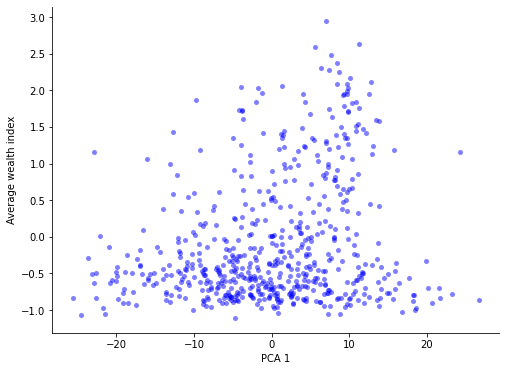

In [0]:
from sklearn.decomposition import PCA

data_all = np.loadtxt('/content/drive/My Drive/Thesis/daytime_analysis/google_image_features_cnn.csv')
x = data_all[:, :-1]
y = data_all[:, -1]
pca = PCA(n_components=1)
pca.fit(x)
proj = pca.transform(x)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(proj[:,0], y, 'o', c='blue', markersize=5, markeredgecolor='none', alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('Average wealth index')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


In [0]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Ridge(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        train_x = train[:, :-1]
        train_y = train[:, -1]
        test_x = test[:, :-1]
        test_y = test[:, -1]
        # reduce dimensions to avoid overfitting
        pca = PCA(n_components=100)
        pca.fit(train_x)
        train_x = pca.transform(train_x)
        test_x = pca.transform(test_x)
        reg.fit(train_x, train_y)
        s = reg.score(test_x, test_y)
        scores.append(s)
    final.append(np.mean(scores))

print('R^2 of the best model: {:.3f}'.format(np.max(final)))


R^2 of the best model: 0.495


In [0]:
!pwd

/content/google_images


Use the nightlights to retrain the CNN and extract features¶

In [0]:
import sys, string, os, shutil

def move_to_group(lightness_small, lightness_big, class_id):
    new_directory = 'data/google_image_cnn/class_' + str(class_id) + '/'
    if not os.path.isdir(new_directory):
        os.makedirs(new_directory)
    for i in range(lightness_small, lightness_big):
        path = '/content/google_images/google_images/' + str(i) + '/'
        for f in os.listdir(path):
            shutil.copyfile(path + f, new_directory + f)

move_to_group(0, 1, 1)
move_to_group(4, 35, 2)
move_to_group(35, 64, 3)

Create Training and Testing set

In [0]:
import os
import numpy as np
import shutil
import random

# # Creating Train / Val / Test folders (One time use)
root_dir = '/content/google_images/data/google_image_cnn/'
classes_dir = ['class_1', 'class_2', 'class_3']

#val_ratio = 0.15
test_ratio = 0.3

for cls in classes_dir:
    os.makedirs(root_dir +'train/' + cls)
    #os.makedirs(root_dir +'/val' + cls)
    os.makedirs(root_dir +'test/' + cls)


    # Creating partitions of the data after shuffling
    src = root_dir + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, test_FileNames = np.split(np.array(allFileNames),[int(len(allFileNames)* (1 - test_ratio))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    #val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    #print('Validation: ', len(val_FileNames))
    print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'train/' + cls)

    #for name in val_FileNames:
        #shutil.copy(name, root_dir +'/val' + cls)

    for name in test_FileNames:
        shutil.copy(name, root_dir +'test/' + cls)


Total images:  308019
Training:  215613
Testing:  92406
Total images:  101858
Training:  71300
Testing:  30558
Total images:  4992
Training:  3494
Testing:  1498


In [0]:
!rm -rf /content/google_images/google_images

In [0]:
# get image features
model_old = VGG16(weights='imagenet', include_top=False)

def get_input_feature(img_path):
    # img = image.load_img(img_path, target_size=(400, 400))
    img = image.load_img(img_path)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model_old.predict(x)
    return features[0]


# train
all_figures = []
trainLabels = []

# need upsampling because of the unbalance of the training classes
path_1 = '/content/google_images/data/google_image_cnn/train/class_1/'
# path_1 = 'google_image_cnn/class_1/'
class_1_files = os.listdir(path_1)
trainLabels += [[1, 0, 0]] * len(class_1_files)
all_figures += [path_1 + i for i in class_1_files]

path_2 = '/content/google_images/data/google_image_cnn/train/class_2/'
# path_2 = 'google_image_cnn/class_2/'
class_2_files = os.listdir(path_2)
trainLabels += [[0, 1, 0]] * len(class_2_files)
all_figures += [path_2 + i for i in class_2_files]

path_3 = '/content/google_images/data/google_image_cnn/train/class_1/'
# path_3 = 'google_image_cnn/class_3/'
class_3_files = os.listdir(path_3)
trainLabels += [[0, 0, 1]] * len(class_3_files)
all_figures += [path_3 + i for i in class_3_files]

os.chdir('/content/drive/My Drive/Thesis/daytime_analysis')
with open('all_figures', 'wb') as fp:
  pickle.dump(all_figures, fp)

os.chdir('/content/drive/My Drive/Thesis/daytime_analysis')
with open('trainLabels', 'wb') as fp:
  pickle.dump(trainLabels, fp)

# a = get_input_feature(all_figures[0])
# pool = Pool(10)
# trainData = pool.map(get_input_feature, all_figures)


NameError: ignored

In [0]:
# get image features

model_old = VGG16(weights='imagenet', include_top=False)


def get_input_feature(img_path):
    # img = image.load_img(img_path, target_size=(400, 400))
    img = image.load_img(img_path)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model_old.predict(x)
    return features[0]


# train
all_figures = []
trainLabels = []

# need upsampling because of the unbalance of the training classes
path_1 = '/content/google_images/data/google_image_cnn/train/class_1/'
# path_1 = 'google_image_cnn/class_1/'
class_1_files = os.listdir(path_1)
trainLabels += [[1, 0, 0]] * len(class_1_files)
all_figures += [path_1 + i for i in class_1_files]

path_2 = '/content/google_images/data/google_image_cnn/train/class_2/'
# path_2 = 'google_image_cnn/class_2/'
class_2_files = os.listdir(path_2)
trainLabels += [[0, 1, 0]] * len(class_2_files)
all_figures += [path_2 + i for i in class_2_files]

path_3 = '/content/google_images/data/google_image_cnn/train/class_1/'
# path_3 = 'google_image_cnn/class_3/'
class_3_files = os.listdir(path_3)
trainLabels += [[0, 0, 1]] * len(class_3_files)
all_figures += [path_3 + i for i in class_3_files]


# a = get_input_feature(all_figures[0])
# pool = Pool(10)
# trainData = pool.map(get_input_feature, all_figures)

trainData = []
t1 = time.time()
for idx, i in enumerate(all_figures):
    a = get_input_feature(i)
    trainData.append(a)
    if idx % 1000 == 0:
        t2 = time.time()
        print(idx)
        print(t2 - t1)
        t1 = time.time()


x_all = np.asarray(trainData)
y_all = np.asarray(trainLabels)

# test
all_figures = []
testLabels = []

path_1 = '/content/google_images/data/google_image_cnn/test/class_1/'
# path_1 = 'google_image_cnn/class_1/'
class_1_files = os.listdir(path_1)
testLabels += [[1, 0, 0]] * len(class_1_files)
all_figures += [path_1 + i for i in class_1_files]

path_2 = '/content/google_images/data/google_image_cnn/test/class_2/'
# path_2 = 'google_image_cnn/class_2/'
class_2_files = os.listdir(path_2)
testLabels += [[0, 1, 0]] * len(class_2_files)
all_figures += [path_2 + i for i in class_2_files]

path_3 = '/content/google_images/data/google_image_cnn/train/class_3/'
# path_3 = 'google_image_cnn/class_3/'
class_3_files = os.listdir(path_3)
testLabels += [[0, 0, 1]] * len(class_3_files)
all_figures += [path_3 + i for i in class_3_files]


# a = get_input_feature(all_figures[0])
# pool = Pool(10)
# testData = pool.map(get_input_feature, all_figures)

testData = []
t1 = time.time()
for idx, i in enumerate(all_figures):
    a = get_input_feature(i)
    testData.append(a)
    if idx % 1000 == 0:
        t2 = time.time()
        print(idx)
        print(t2 - t1)
        t1 = time.time()


x_all_test = np.asarray(testData)
y_all_test = np.asarray(testLabels)

# np.savez('google_image_feature.npz', x_all=x_all, y_all=y_all)
np.savez('google_image_feature_upsampling.npz', x_all=x_all, y_all=y_all, 
         x_all_test=x_all_test, y_all_test=y_all_test)

# npzfile = np.load('google_image_feature_upsampling.npz')
# print npzfile.files
# x_all = npzfile['x_all']
# y_all = npzfile['y_all']


x_train = x_all
x_test = x_all_test
y_train = y_all
y_test = y_all_test


# the model configuration: 
# https://github.com/nealjean/predicting-poverty/blob/master/model/predicting_poverty_deploy.prototxt
model = Sequential()
model.add(Convolution2D(4096, 6, 6, activation='relu', input_shape=(12, 12, 512), subsample=(6, 6), name='input'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, 1, 1, activation='relu', subsample=(1, 1), name='conv_7'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, 1, 1, subsample=(1, 1), name='conv_8'))
model.add(AveragePooling2D((2, 2), strides=(1, 1), name='add_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(3))
model.add(Activation("softmax"))

opt = SGD(lr=1e-2)
# model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


model.fit(x_train, y_train, batch_size=100, nb_epoch=10, verbose=1)

score = model.evaluate(x_test, y_test, verbose=0)  # 0.778 after 4 epoch
print(score)












0
6.353403568267822
1000
19.86513614654541
2000
19.743985414505005
3000
19.757680416107178
4000
19.804747343063354
5000
19.704426288604736
6000
19.68263864517212
7000
19.5633647441864
8000
19.68484377861023
9000
19.541710376739502
10000
19.62989377975464
11000
19.622095823287964
12000
19.588867664337158
13000
19.591108322143555
14000
19.655876398086548
15000
19.381463527679443
16000
19.389185667037964
17000
19.39171051979065
18000
19.295127391815186
19000
19.349539041519165
20000
19.48043417930603
21000
19.430766582489014
22000
19.443402767181396
23000
19.325073957443237
24000
19.45539093017578
25000
19.520007610321045
26000
19.494882345199585
27000
19.623171091079712
28000
19.64610719680786
29000
19.873650074005127
30000
19.75463628768921
31000
19.784753799438477
32000
19.711864948272705
33000
20.150782108306885
34000
20.170843601226807
35000
19.798086166381836


In [0]:
#import os
#os.chdir('/content/google_images/data')
#!rm -rf google_image_cnn


In [0]:
# get features
npzfile = np.load('/content/drive/My Drive/Thesis/nightlight.npz')
print npzfile.files
top_left_x_coords = npzfile['top_left_x_coords']
top_left_y_coords = npzfile['top_left_y_coords']
bands_data = npzfile['bands_data']


def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx


model_select = Model(input=model.input, output=model.get_layer('add_pool').output)


images_name = {} 
for i in range(64):
    if i == 0: 
        dir_ = '/content/google_images/google_images/' + str(i) + '/'
    else:
        dir_ = '/content/google_images/google_images/' + str(i+3) + '/'
    image_files = os.listdir(dir_)
    for f in image_files:
        images_name[f] = i


def get_input_feature_2(img_path):
    # img = image.load_img(img_path, target_size=(400, 400))
    img = image.load_img(img_path)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model_old.predict(x)
    pool_features = model_select.predict(features)
    return pool_features[0]

def get_daytime_feature(sample):
    idx, wealth, x, y = sample
    print idx
    lon_idx, lat_idx = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    left_idx = lon_idx - 5
    right_idx = lon_idx + 4
    up_idx = lat_idx - 5
    low_idx = lat_idx + 4
    features_100 = []
    for i in xrange(left_idx, right_idx + 1):
        for j in xrange(up_idx, low_idx + 1):
            file_name = str(i) + '_' + str(j) + '.jpg'
            if file_name in images_name:
                luminosity = images_name[file_name]
                feature = get_input_feature_2('/content/google_images/google_images/' + str(luminosity) + '/' + file_name)
                features_100.append(feature)
    if len(features_100) == 0:
        print('nononono: ' + str(idx))
        return np.asarray([np.nan] * 4096 + [wealth]).tolist()
    else:
        features_100 = np.asarray(features_100)
        return np.append(np.mean(features_100, axis=0), wealth).tolist()


clusters = pd.read_csv('/content/drive/My Drive/Thesis/DHS_Data/bangladesh_cluster_avg_asset_2013_updated_new.csv')
clusters['feature'] = clusters.apply(lambda x: get_daytime_feature([x['cluster'], x['wlthindf'], 
                                                                    x['longitude'], x['latitude']]), axis=1)

data_all = clusters['feature']
data_all = np.asarray([i for i in data_all])
data_all = data_all[~np.isnan(data_all).any(axis=1)]

np.savetxt('/content/drive/My Drive/Thesis/daytime_analysis/google_image_features_cnn_retrain.csv', data_all)


In [0]:
data_all = np.loadtxt('/content/drive/My Drive/Thesis/daytime_analysis/google_image_features_cnn_retrain.csv')

alphas_list = np.logspace(-1, 5, 7)

final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Ridge(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        train_x = train[:, :-1]
        train_y = train[:, -1]
        test_x = test[:, :-1]
        test_y = test[:, -1]
        # reduce dimensions to avoid overfitting
        pca = PCA(n_components=100)
        pca.fit(train_x)
        train_x = pca.transform(train_x)
        test_x = pca.transform(test_x)
        reg.fit(train_x, train_y)
        s = reg.score(test_x, test_y)
        scores.append(s)
    final.append(np.mean(scores))

print 'R^2 of the best model: {:.3f}'.format(np.max(final))
